# Arize Tutorial: Logging Predictions and SHAP Together

Let's get started on using Arize! ✨

Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models. 

In this tutorial, we will using our Score Categorical model for predicting if someone has breast cancer or not to showcase one of the many ways of using the `arize.bulk_log` to fit your model and data needs.

### Why Use Multiple Log/Bulk_Log Calls 🤔
Sometimes, we want to `bulk_log` predictions during production and store our `prediction_ids` right away for model tracking, but we don't have ground truth labels avaliable until much later. Othertimes, they become avaliable at the same time. Depending on your situation, you may need to use `bulk_log` differently.

**In this notebook, we will show how to `bulk_log` using `prediction_ids` to only log only your predictions and SHAP values 🚀**

For more of our usage case tutorials, visit our other [example tutorials](https://arize.gitbook.io/arize/examples).

In general, if any part if your data (including `features`) become avaliable later and you can't log them right away, Arize provides the functionality of matching them through using `prediction_ids`, which is the only required field aside from `model_id`.

### Running This Notebook
1. Save a copy in Google Drive for yourself.
2. Step through each section below, pressing play on the code blocks to run the cells.
3. In Step 2, use your own Org and API key from your Arize account. 



## Step 1: Load Data and Build Model

In [ ]:
import numpy as np
import pandas as pd
import uuid
import concurrent.futures as cf
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

def map_proba(y_pred, y_pred_proba):
    """
    Input:
    y_pred (1-dim) and y_pred_proba (n-dim) from sklearn
    Output:
    y_pred_scores (1-dim) np.array for the probability of only the predicted class
    """
    y_pred_scores = [y_pred_proba[i][int(y_pred[i])] for i in range(len(y_pred))]
    return pd.Series(y_pred_scores)

###############################################################################
# 1 Load data and split data
data = datasets.load_breast_cancer()
X, y = datasets.load_breast_cancer(return_X_y=True)

# NOTE: We need to set y.astype(str) since BINARY expected non-integer.
X, y = X.astype(np.float32), y.astype(str)
X, y = pd.DataFrame(X, columns=data['feature_names']), pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

###############################################################################
# 2 Fit a simple logistic regression model
clf = LogisticRegression(max_iter=3000, verbose=False).fit(X_train, y_train)

# 3 Use the model to generate predictions
y_train_pred = clf.predict(X_train)
y_train_pred_proba = clf.predict_proba(X_train)

y_val_pred = clf.predict(X_val)
y_val_pred_proba = clf.predict_proba(X_val)

y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)

# 3.5 Change the format for prediction_scores
y_train_pred_score = map_proba(y_train_pred, y_train_pred_proba)
y_val_pred_score = map_proba(y_val_pred, y_val_pred_proba)
y_test_pred_score = map_proba(y_test_pred, y_test_pred_proba)

print('Step 1 ✅: Load Data & Build Model Done!')

Step 1 ✅: Load Data & Build Model Done!


## Step 2: Import and Setup Arize Client
You can find your `API_KEY` and `ORGANIZATION_KEY` at on your [Settings Page](https://app.arize.com/admin). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging. 
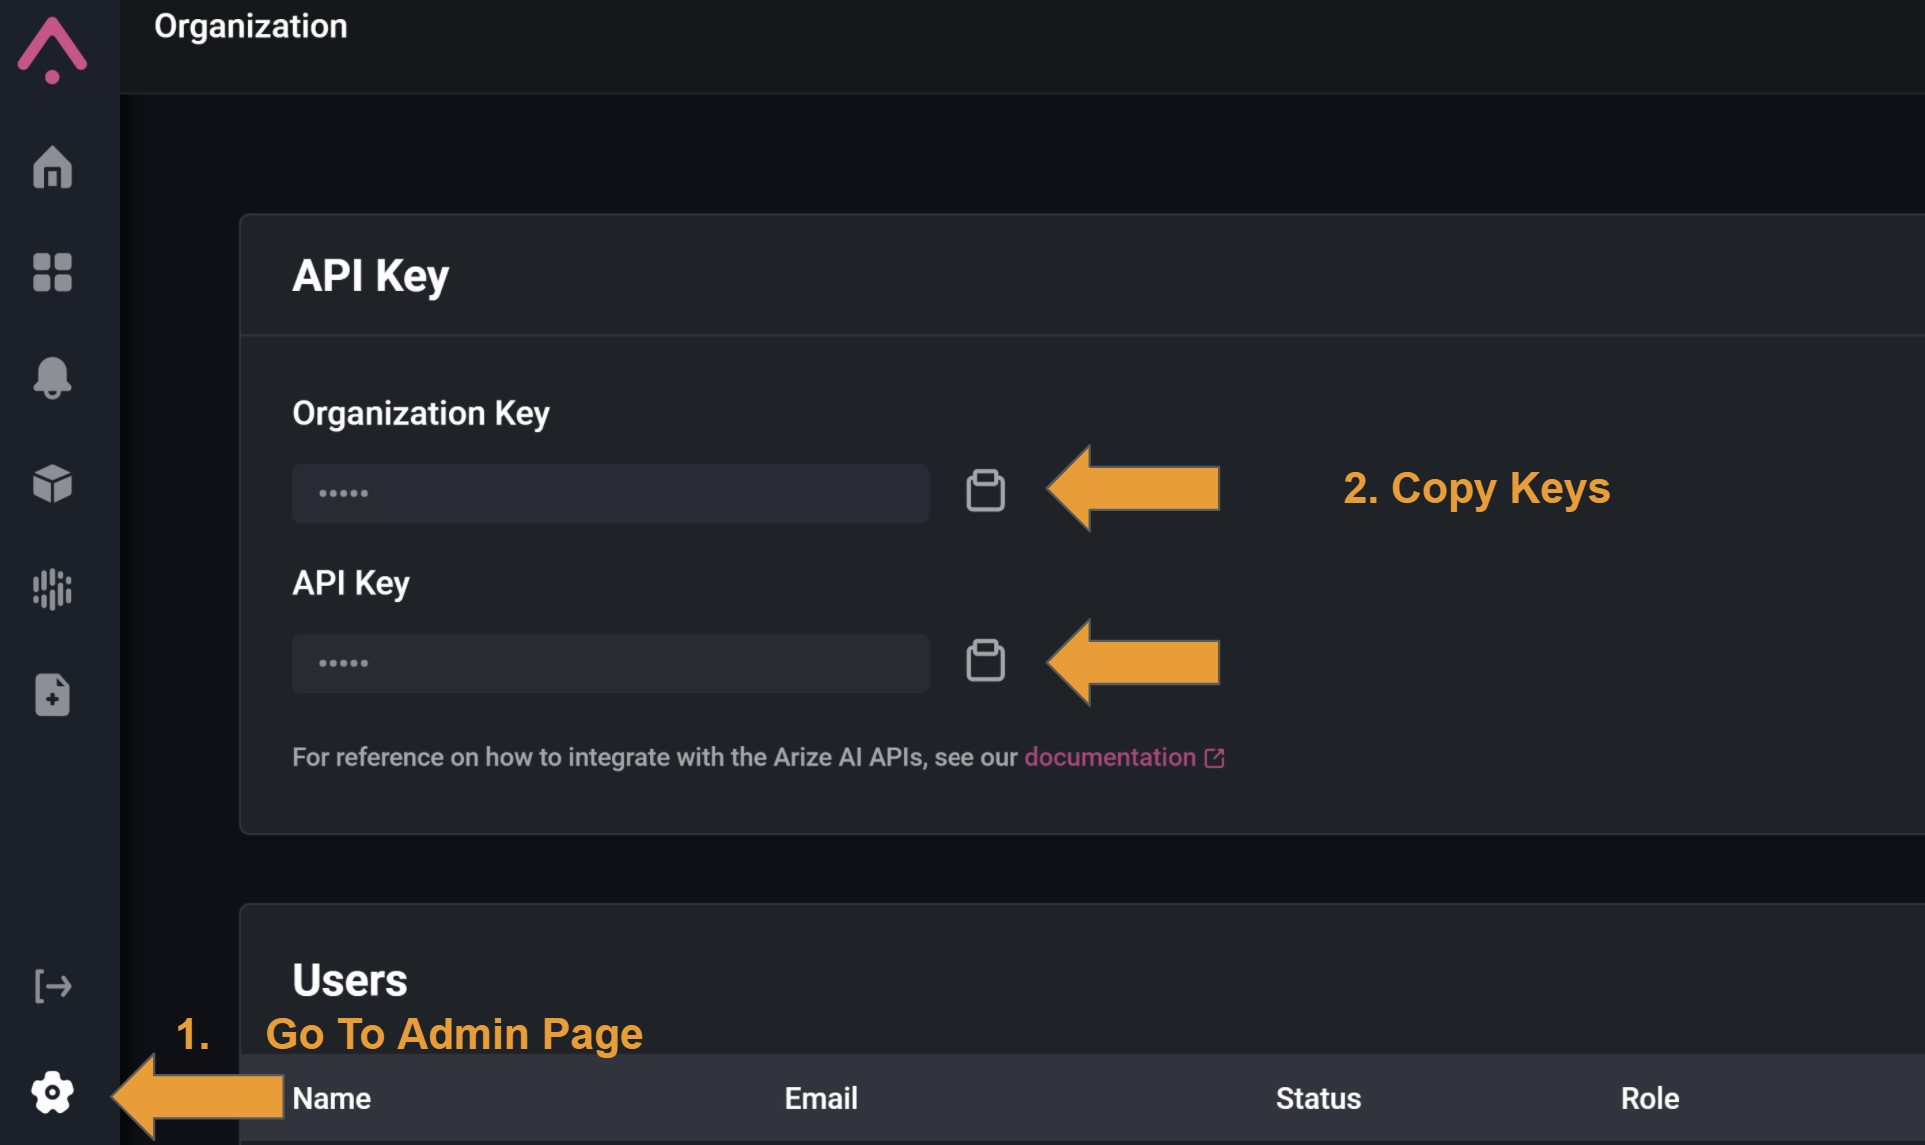

In [ ]:
!pip install arize -q
from arize.api import Client
from arize.types import ModelTypes

ORGANIZATION_KEY = 'ORGANIZATION_KEY'
API_KEY = 'API_KEY'
arize = Client(organization_key=ORGANIZATION_KEY, api_key=API_KEY)

model_id = 'logging_tutorial_shap_only'
model_version = '1.0'
model_type = ModelTypes.SCORE_CATEGORICAL

print('Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!')

     |████████████████████████████████| 1.3MB 15.5MB/s 
ERROR: tensorflow-metadata 0.29.0 has requirement googleapis-common-protos<2,>=1.52.0, but you'll have googleapis-common-protos 1.51.0 which is incompatible.
Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!


# Logging Tutorial
Next steps simulate production environment. These are some helper functions you can use.

In [ ]:
# OPTIONAL: Helper to listen to response code to ensure successful delivery
def arize_responses_helper(responses):
    """
    Helper function for checking arize responses for both bulk and non-bulk
    """
    def check_result(response):
        res = response.result()
        assert res.status_code == 200, f'future failed with response code {res.status_code}, {res.text}'
    if type(responses) != list:
        check_result(responses)
    else:
        for response in cf.as_completed(responses):
            check_result(response)
# OPTIONAL: We can manually specify when records are made
def simulate_production_timestamps(num_entries, days=30):
    """
    Takes in: number of entries used for bulk_log, and number of days we want simulate back trace
    Returns prediction_timestamps arguement for bulk_log, uniformally distributed over time period
    """
    current_time = datetime.datetime.now().timestamp()
    earlier_time = (datetime.datetime.now() - datetime.timedelta(days=days)).timestamp()
    optional_prediction_timestamp = np.linspace(earlier_time, current_time, num=num_entries)
    optional_prediction_timestamp = pd.Series(optional_prediction_timestamp.astype(int))
    return optional_prediction_timestamp

## Step 3: Generating and Formatting SHAP Values
**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model.

For more in-depth usage of the `shap` library, visit [SHAP Core Explainers](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.Explainer.html) and pick an explainer specific to your machine learning model. `shap.Explainer` is the default explainer that will matches model type, but you can specify your own type. For example, you can choose to use for example `shap.TreeExplainer`, but it won't work on models such as `sklearn.LinearModel.LogisticRegression`.

We create this helper function `get_shap_values` to format the data and/or create visualizations for our shap values. We will store our results in a `pd.DataFrame` with matching columns for logging later.

     |████████████████████████████████| 358kB 7.8MB/s 


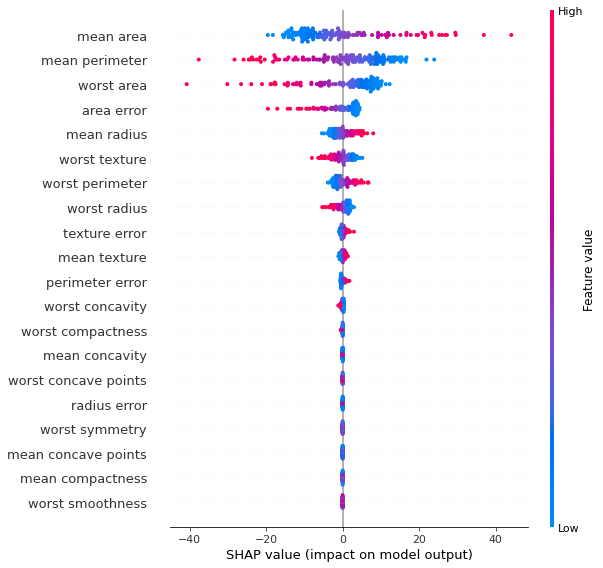

Part 3 ✅: If no errors showed up, you have just generated 143 shap values!


In [ ]:
!pip install shap -q
import shap

def get_shap_values(model, X_train, X_test, ExplainerType, show_graph=False):
    # Linear Models directly generate in the shape loggable to Arize
    if ExplainerType == shap.LinearExplainer:
        explainer = shap.LinearExplainer(model, X_train)
        shap_values = explainer.shap_values(X_test)

    # We need to collaps the class probability for Tree Models.
    elif ExplainerType == shap.TreeExplainer:
        explainer = shap.TreeExplainer(model, X_train)
        shap_values = explainer.shap_values(X_test)
        # This sums over the first dimension, adding up class shap values
        shap_values = np.sum(np.array(shap_values), 0)

    # Model Agnostic Explainers 
    else:
        explainer = shap.KernelExplainer(model.predict_proba, X_train)
        shap_values = explainer.shap_values(X_test)
        shap_values = np.sum(np.array(shap_values), 0)

    # When not in production, it can be helpful to check graphs for feature explainability
    if show_graph:
        shap.summary_plot(shap_values, X_test, feature_names=data['feature_names'])
    
    # NOTE: Arize API expects a DataFrame of the same shape and column name as the model features.
    return pd.DataFrame(shap_values, columns=data['feature_names'])

shap_values = get_shap_values(clf, X_train, X_test, shap.LinearExplainer, show_graph=True)
print('Part 3 ✅: If no errors showed up, you have just generated {} shap values!'.format(len(shap_values)))

## Step 4: Bulk Logging Predictions and SHAP
We can log predictions in bulk to Arize first, and match various other values such as actuals, explainability (i.e SHAP), or even features later. 

In this example, we will use `arize.bulk_log` to only log the `prediction_labels`, `features`, and `shap_values`  directly assuming you had it avaliable. This is to simulate situations where we want to have features and generated explainability avaliable, but are still waiting on `actuals`.

You can see our `arize.bulk_log` documentations [here](https://arize.gitbook.io/arize/apis/python-sdk-1/arize.bulk_log) ✨.

**Note: We left the optional arguements as** `None` **for your reference, but you can leave them out entirely!**

In [ ]:
import datetime
# Generating Predictions
y_pred = pd.Series(clf.predict(X_test))
num_preds = len(y_pred) # num_preds == 143

# Generating Prediction IDs
ids_df = pd.DataFrame([str(uuid.uuid4()) for _ in range(num_preds)])

# Generating simulated prediction_timestamps over 30 days
optional_prediction_timestamps = simulate_production_timestamps(len(y_test_pred), days=30)

# Logging the Predictions, Features, and Actuals only! (note: Features are optional too)
log_predictions_responses = arize.bulk_log(
    # Required arguments below
    model_id=model_id,
    prediction_ids=ids_df,
    # Optional arguments
    model_version=model_version,
    prediction_labels=y_pred,
    actual_labels=None,
    shap_values=shap_values,
    features=X_test, # we recommend logging features with predictions
    model_type=model_type, # we recommend using model_type on first time logging to Arize
    feature_names_overwrite=None,
    prediction_timestamps=optional_prediction_timestamps # OPTIONAL: simulating production timeline
    )

arize_responses_helper(log_predictions_responses)
print('Step 4 ✅: If no errors appear, you just logged {} total predictions, features, and shap values to Arize!'.format(num_preds))

Step 4 ✅: If no errors appear, you just logged 143 total predictions, features, and shap values to Arize!
